<a href="https://colab.research.google.com/github/SvetlanaTsim/ml_in_business/blob/main/lesson_07/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 7. Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях

## Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

# Модель оттока для данных по телекому Telco Customer Churn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

# Загрузка данных

In [3]:
pd.set_option('display.max_columns', None)

Ссылка на google drive: https://drive.google.com/file/d/1lh7xHLCg-FluHkYYJweCA_O5iuTZFUcc

In [4]:
!wget 'https://drive.google.com/uc?export=download&id=1lh7xHLCg-FluHkYYJweCA_O5iuTZFUcc' -O churn_data.csv

--2023-01-17 14:52:10--  https://drive.google.com/uc?export=download&id=1lh7xHLCg-FluHkYYJweCA_O5iuTZFUcc
Resolving drive.google.com (drive.google.com)... 142.250.4.139, 142.250.4.113, 142.250.4.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-bs-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ls3d31huh130s5f2dn6orjs9sgco5da/1673967075000/04420567413078840451/*/1lh7xHLCg-FluHkYYJweCA_O5iuTZFUcc?e=download&uuid=18625456-a50d-443a-822b-8c589de84e1d [following]
--2023-01-17 14:52:10--  https://doc-0g-bs-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ls3d31huh130s5f2dn6orjs9sgco5da/1673967075000/04420567413078840451/*/1lh7xHLCg-FluHkYYJweCA_O5iuTZFUcc?e=download&uuid=18625456-a50d-443a-822b-8c589de84e1d
Resolving doc-0g-bs-docs.googleusercontent.com (doc-0g-bs-docs.googleusercontent.com)... 74.125.24.132, 2404:6800:

## Задание
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [35]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 31.6 MB/s eta 0:00:00


In [100]:
df = pd.read_csv('churn_data.csv', sep = ',')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [101]:
categorical_columns = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',  'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'Contract', 'PaymentMethod']
continuous_columns = ['tenure', 'MonthlyCharges', ]
binary_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [102]:
for col in binary_columns:
    df = df.replace({col : { 'Yes' : 1, 'No' : 0}})

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,Yes


In [103]:
feature_names = categorical_columns + continuous_columns + binary_columns 

In [104]:
df = df.replace({'Churn' : { 'Yes' : 1, 'No' : 0}})
df['Churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [105]:
X = df[feature_names]
y = df['Churn']
X.head()

,gender,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,tenure,MonthlyCharges,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
0,Female,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Electronic check,1,29.85,0,1,0,0,1
1,Male,No,DSL,Yes,No,Yes,No,No,No,One year,Mailed check,34,56.95,0,0,0,1,0
2,Male,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Mailed check,2,53.85,0,0,0,1,1
3,Male,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,Bank transfer (automatic),45,42.30,0,0,0,0,0
4,Female,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check,2,70.70,0,0,0,1,1


In [106]:
X.columns

Index(['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaymentMethod', 'tenure',
       'MonthlyCharges', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'PaperlessBilling'],
      dtype='object')

In [107]:
from imblearn.over_sampling import RandomOverSampler

In [108]:
ros = RandomOverSampler(random_state=0)

X, y = ros.fit_resample(X, y)

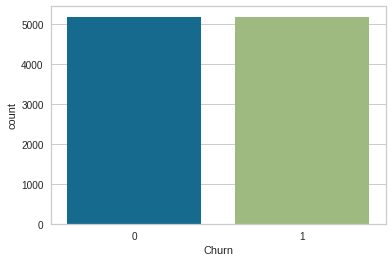

In [109]:
ax = sns.countplot(x=y)

In [110]:
#разделим данные на train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [111]:
!pip install catboost
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
model = CatBoostClassifier(random_state=42, n_estimators=50, cat_features=categorical_columns)

In [51]:
# from sklearn.ensemble import ExtraTreesClassifier

# model = ExtraTreesClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)

In [113]:
model.fit(X_train, y_train)

Learning rate set to 0.385455
0:	learn: 0.6052283	total: 22.6ms	remaining: 1.1s
1:	learn: 0.5489703	total: 47.2ms	remaining: 1.13s
2:	learn: 0.5235557	total: 66.3ms	remaining: 1.04s
3:	learn: 0.5083172	total: 72.4ms	remaining: 832ms
4:	learn: 0.4935072	total: 80.2ms	remaining: 722ms
5:	learn: 0.4879763	total: 85.2ms	remaining: 625ms
6:	learn: 0.4794426	total: 94.1ms	remaining: 578ms
7:	learn: 0.4742994	total: 102ms	remaining: 536ms
8:	learn: 0.4699760	total: 110ms	remaining: 499ms
9:	learn: 0.4689747	total: 113ms	remaining: 453ms
10:	learn: 0.4651279	total: 121ms	remaining: 430ms
11:	learn: 0.4622209	total: 130ms	remaining: 410ms
12:	learn: 0.4591845	total: 139ms	remaining: 395ms
13:	learn: 0.4570737	total: 146ms	remaining: 376ms
14:	learn: 0.4554274	total: 160ms	remaining: 374ms
15:	learn: 0.4537638	total: 182ms	remaining: 387ms
16:	learn: 0.4535950	total: 202ms	remaining: 392ms
17:	learn: 0.4521726	total: 219ms	remaining: 390ms
18:	learn: 0.4514749	total: 240ms	remaining: 392ms
19:	l

In [114]:
# наши прогнозы для тестовой выборки
preds_prob = model.predict_proba(X_test)[:, 1]
preds_prob[:10]

array([0.90741857, 0.19765796, 0.86147974, 0.7977659 , 0.16495779,
       0.90027126, 0.33878158, 0.46891563, 0.80265729, 0.95015614])

In [115]:
#пока просто посмотрим на стандартные прогнозы
preds = model.predict(X_test)

preds[:10]

array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1])

In [116]:
#посмотрим статистку со базовым прогнозом. f1 score по 1му классу - 0.89, что очень хорошо
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1290
           1       0.75      0.82      0.79      1297

    accuracy                           0.78      2587
   macro avg       0.78      0.78      0.78      2587
weighted avg       0.78      0.78      0.78      2587



Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [121]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [122]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_prob)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4344160719851115, F-Score=0.798, Precision=0.731, Recall=0.879


In [123]:
#посмотрим статистку со базовым прогнозом. f1 score по 1му классу - 0.89, что очень хорошо
print(classification_report(y_test, preds_prob > thresholds[ix]))

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      1290
           1       0.73      0.88      0.80      1297

    accuracy                           0.78      2587
   macro avg       0.79      0.78      0.77      2587
weighted avg       0.79      0.78      0.77      2587



- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)

In [124]:
import shap

# load JS visualization code to notebook
shap.initjs()

import matplotlib.pyplot as plt
%matplotlib inline

In [125]:
# строим модель объяснения в SHAP
%%time
shap.initjs() # для работы в колабе

explainer = shap.TreeExplainer(model)

shap_values_all = explainer.shap_values(X_test)

CPU times: user 350 ms, sys: 10 ms, total: 360 ms
Wall time: 249 ms


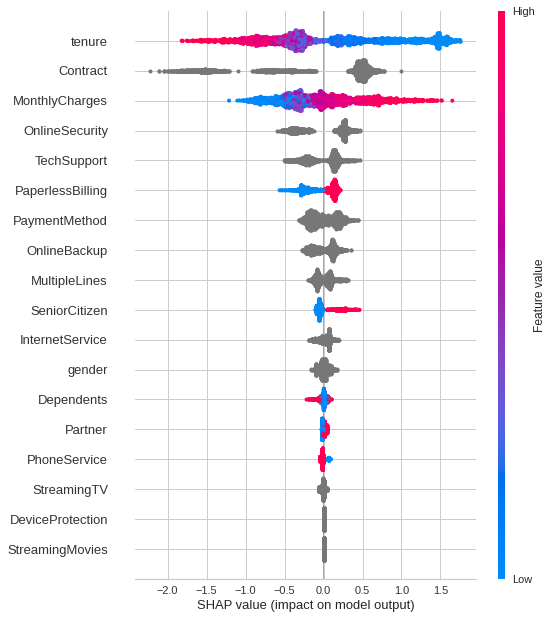

CPU times: user 874 ms, sys: 467 ms, total: 1.34 s
Wall time: 838 ms


In [126]:
%%time
shap.summary_plot(shap_values_all, X_test, feature_names=feature_names)

## Интерпретация

1. Больше всего вляет на отток показатель tenure. Чем он меньше, тем выше риск оттока. Чем он, выше тем ниже риск оттока.
2. MonthlyCharges - чем больше, тем выше риск оттока, чем ниже - тем меньше.
3. PaperlessBilling - чем больше, тем выше риск оттока, чем ниже, тем меньше. 
4. SeniorCitizen - чем больше, тем выше риск оттока, чем ниже, тем меньше.

- для топ 10%

In [168]:
X_test.head()

,gender,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,tenure,MonthlyCharges,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
1730,Male,Yes,DSL,No,No,No,No,Yes,No,Month-to-month,Electronic check,1,59.85,0,0,0,1,1
6022,Female,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Credit card (automatic),20,18.90,0,0,0,1,1
7778,Female,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Credit card (automatic),1,74.30,0,0,0,1,1
4443,Female,No,DSL,No,No,No,No,No,No,Month-to-month,Mailed check,1,44.75,0,0,0,1,0
5412,Male,Yes,Fiber optic,No,Yes,No,Yes,No,No,One year,Bank transfer (automatic),61,85.55,1,1,0,1,1


In [169]:
X_test_probs = X_test.copy()

In [170]:
X_test_probs['probs'] = preds_prob
X_test_probs.head()

,gender,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,tenure,MonthlyCharges,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,probs
1730,Male,Yes,DSL,No,No,No,No,Yes,No,Month-to-month,Electronic check,1,59.85,0,0,0,1,1,0.907419
6022,Female,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Credit card (automatic),20,18.90,0,0,0,1,1,0.197658
7778,Female,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Credit card (automatic),1,74.30,0,0,0,1,1,0.861480
4443,Female,No,DSL,No,No,No,No,No,No,Month-to-month,Mailed check,1,44.75,0,0,0,1,0,0.797766
5412,Male,Yes,Fiber optic,No,Yes,No,Yes,No,No,One year,Bank transfer (automatic),61,85.55,1,1,0,1,1,0.164958


In [171]:
X_test_probs.describe()

,tenure,MonthlyCharges,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,probs
count,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000,2587.000000
mean,27.723232,67.614032,0.188635,0.436026,0.258214,0.904136,0.637418,0.503647
std,23.832944,28.685203,0.391294,0.495986,0.437737,0.294461,0.480839,0.313146
min,0.000000,18.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005605
25%,5.000000,45.250000,0.000000,0.000000,0.000000,1.000000,0.000000,0.210391
50%,22.000000,74.650000,0.000000,0.000000,0.000000,1.000000,1.000000,0.553992
75%,48.000000,90.550000,0.000000,1.000000,1.000000,1.000000,1.000000,0.794430
max,72.000000,118.600000,1.000000,1.000000,1.000000,1.000000,1.000000,0.963079


In [172]:
len(X_test_probs)

2587

In [173]:
X_test_sort = X_test_probs.sort_values(by='probs', ascending=False)

idx = int(np.ceil(len(X_test_probs) * 0.1))

X_test_10 = X_test_sort.iloc[:idx, :]

X_test_10.head()

,gender,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,tenure,MonthlyCharges,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,probs
20,Male,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Electronic check,1,39.65,1,0,0,0,1,0.963079
1334,Female,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Electronic check,1,25.20,1,0,0,0,1,0.961722
5186,Female,No phone service,DSL,No,No,No,No,Yes,No,Month-to-month,Electronic check,1,36.45,1,0,0,0,1,0.961722
31,Male,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Credit card (automatic),2,95.50,1,1,0,1,1,0.961004
7952,Male,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Electronic check,2,94.00,1,0,0,1,1,0.957704


In [174]:
X_test_10.drop('probs', axis = 1, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [175]:
X_test_10.head()

,gender,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,tenure,MonthlyCharges,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
20,Male,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Electronic check,1,39.65,1,0,0,0,1
1334,Female,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Electronic check,1,25.20,1,0,0,0,1
5186,Female,No phone service,DSL,No,No,No,No,Yes,No,Month-to-month,Electronic check,1,36.45,1,0,0,0,1
31,Male,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Credit card (automatic),2,95.50,1,1,0,1,1
7952,Male,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Electronic check,2,94.00,1,0,0,1,1


In [176]:
len(X_test_10)

259

In [177]:
%%time
shap_values_10 = explainer.shap_values(X_test_10)

CPU times: user 111 ms, sys: 8.02 ms, total: 119 ms
Wall time: 76.2 ms


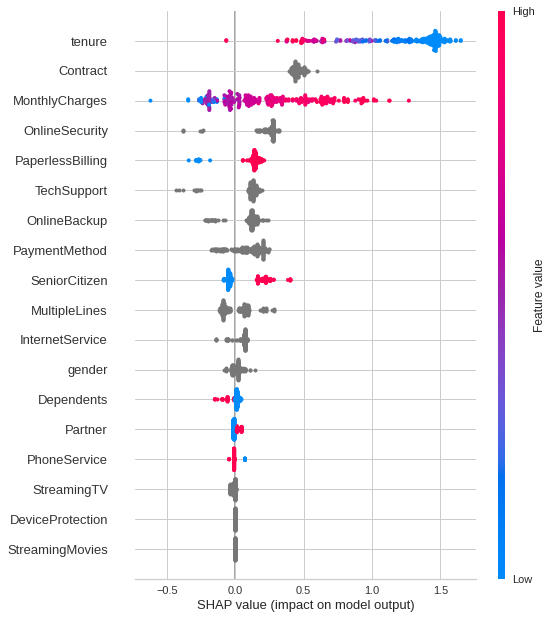

CPU times: user 493 ms, sys: 306 ms, total: 799 ms
Wall time: 468 ms


In [178]:
%%time
shap.summary_plot(shap_values_10, X_test_10, feature_names=feature_names)

## Интерпретация
Для 10% наиболее вероятных к оттоку клиентов по версии модели: 
1. Больше всего вляет на отток показатель tenure. Чем он меньше, тем выше риск оттока. Хотя все клиенты по влиянию этого признака очень вероятны к оттоку (мы их и выбирали)
2. MonthlyCharges - чем больше, тем выше риск оттока, чем ниже - тем меньше.
3. PaperlessBilling - чем больше, тем выше риск оттока, чем ниже, тем меньше. 
4. SeniorCitizen - чем больше, тем выше риск оттока, чем ниже, тем меньше.

- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [195]:
#сделаем для 5 различных наблюдений
import random

idxs = random.sample(range(len(X_test)), 5)
idxs 

[159, 2181, 1088, 2136, 1021]

In [206]:
%%time
# visualize the first prediction's explanation
shap.initjs()
n = 0
idx = idxs[n]
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_test.iloc[idx,:])

CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 49 ms


## Интерпретация
Для данного клиента: 
1. Клиент скорее не уйдет в отток - вероятность -3.71
2. Вероятность увеличивает признак tenure = 10. 
3. Остальные признаки уменьшаяют вероятность оттока. Особенно признаки Contact и MonthlyCharges.

In [207]:
%%time
n += 1
# visualize the first prediction's explanation
shap.initjs()
idx = idxs[n]
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_test.iloc[idx,:])

CPU times: user 10.9 ms, sys: 1.99 ms, total: 12.9 ms
Wall time: 13.9 ms


## Интерпретация
Для данного клиента: 
1. Клиент скорее уйдет в отток - вероятность 2.24
2. Вероятность уменьшают признаки MonthlyCharges и MultipleLines
3. Отальные признаки увеличивают вероятность, особенно признак tenure = 1. 

In [208]:
%%time
n += 1
# visualize the first prediction's explanation
shap.initjs()
idx = idxs[n]
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_test.iloc[idx,:])

CPU times: user 10.4 ms, sys: 2 ms, total: 12.4 ms
Wall time: 14.6 ms


## Интерпретация
Для данного клиента: 
1. Клиент скорее уйдет в отток - вероятность 3.03
2. Вероятность уменьшают признаки SeniorCitizen и др.
3. Отальные признаки увеличивают вероятность, особенно признак tenure = 1. 

In [209]:
%%time
n += 1
# visualize the first prediction's explanation
shap.initjs()
idx = idxs[n]
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_test.iloc[idx,:])

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 13 ms


## Интерпретация
Для данного клиента: 
1. Клиент скорее уйдет в отток - вероятность 0.5. При базовом значении -0.1868
2. Много признаков и увеличивающих вероятность оттока (больше всего MonthlyCharges), так и уменьшающих вероятность (больше всего tenure)

In [210]:
n += 1
# visualize the first prediction's explanation
shap.initjs()
idx = idxs[n]
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_test.iloc[idx,:])

## Интерпретация
Для данного клиента: 
1. Клиент скорее уйдет в отток - вероятность 0.66. При базовом значении -0.1868
2. Много признаков и увеличивающих вероятность оттока (больше всего Contract = Month-to-month, видимо потому что клиента не держит головой контракт), так и уменьшающих вероятность (больше всего MonthlyCharges=40.1)